In [2]:
from collections import Counter
from dotenv import load_dotenv
from hyppo.ksample import Energy
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, mannwhitneyu
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

c:\Users\Richelle\Documents\Data Science\DSA4263-Project-Twitter-Bots\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
twitter_accounts_df = pd.read_csv("../data/twitter_human_bots_dataset.csv", index_col=0)
twitter_translated_embeddings_df = pd.read_csv("./data/twitter_translated_embeddings.csv")

In [6]:
twitter_accounts_df

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,2009-08-08 13:11:15,True,False,"Role: Stock Taker. Past Roles: Nanny, Sales As...",651,139,1105,False,63963107,en,Kingston Upon Hull,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/5844684414...,butchsekab,340,False,0.084,4028,human
37434,2013-01-05 21:35:37,False,False,KINGDOM LANDLORD #FreeCornBread,8839,1121486,605,True,1064042478,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9511349456...,Mathieu_Era,24970,True,8.976,2782,human
37435,2013-01-14 18:05:54,True,False,Bienvenid@s al Twitter Oficial de Sergio Dalma...,399,85630,190,False,1089732602,it,En constante movimiento,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1174733822...,SDalmaoficial,6174,True,2.226,2773,human
37436,2012-09-10 16:12:02,False,False,Just a good guy wrapped up in a bad system.\nA...,967,138,166,True,815529979,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1265807908...,VinceYearly,982,False,0.339,2899,human


In [33]:
bot_indices = twitter_accounts_df["account_type"]=="bot"
human_indices = twitter_accounts_df["account_type"]=="human"

# Hypothesis 1: Bots have a lower follower-to-friend ratio compared to human accounts
Bots are often used to artificially boost engagement or amplify content visibility. To appear active and legitimate, they tend to follow large numbers of accounts, including both other bots and real users. This can explain why many bots also have high follower counts these are often other bots within coordinated networks.
However, bots generally lack reciprocation from real users because their mass-following behavior is easily recognizable as suspicious or inauthentic. As a result, their follower-to-friend ratio remains significantly lower than that of human accounts, reflecting their one-sided and automated interaction patterns.

In [ ]:
twitter_accounts_df["followers_friends_ratio"] = twitter_accounts_df["followers_count"] / twitter_accounts_df["friends_count"]

/Users/han-ying/Downloads/DSA4263 - twitter/twitter_bots_env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


followers_friends_ratio
inf            5376
0.000000        221
1.000000         85
0.500000         64
0.333333         59
               ... 
3528.268145       1
602.938852        1
1.043967          1
1.221818          1
450.684211        1
Name: count, Length: 26700, dtype: int64

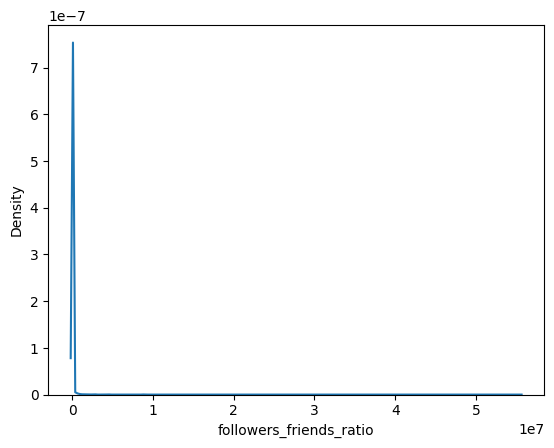

In [20]:
sns.kdeplot(x=twitter_accounts_df["followers_friends_ratio"])
twitter_accounts_df["followers_friends_ratio"].value_counts()

Many accounts have inifinite or extremely large follower-to-friend ratios due to 0 friend/follwoer counts. To handle this, the ratio was transformed as log((followers+1)/(friends+1))

In [24]:
twitter_accounts_df["log_followers_friends_ratio"] = np.log((twitter_accounts_df["followers_count"] + 1) / (twitter_accounts_df["friends_count"] + 1))

<Axes: xlabel='log_followers_friends_ratio', ylabel='Density'>

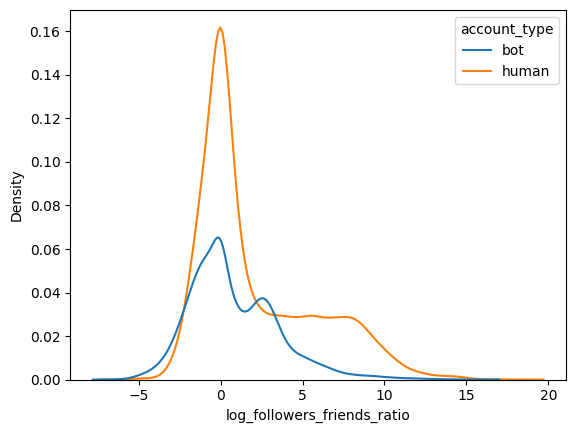

In [25]:
sns.kdeplot(data=twitter_accounts_df, x="log_followers_friends_ratio", hue="account_type")

Since `log_followers_friends_ratio` is not normally distributed, test for statistical significance using non-parametric the Mann-Whitney U test.

In [36]:
bots_ratio = twitter_accounts_df["log_followers_friends_ratio"][bot_indices]
humans_ratio = twitter_accounts_df["log_followers_friends_ratio"][human_indices]
stat, p = mannwhitneyu(bots_ratio, humans_ratio, alternative="two-sided")
print(f"Mann-Whitney U p-value: {p}")

Mann-Whitney U p-value: 4.2987536059436695e-207


p-value is observed to be <0.05 which means the difference is statistically significant, hence we can support the hypothesis that bots tend to follow more users while having far fewer followers.

# Hypothesis 2: Bots and humans use distinct language patterns in their profile descriptions.

Profile descriptions reflect how users present themselves on Twitter. Human users typically write with personalized, expressive, and varied language, whereas bots often employ generic, templated, or keyword-driven text to appear relevant or to advertise specific content.

## Method
To assess whether profile-language differs systematically between bots and humans we used both token-level and representation-level analyses.

### Token-Level:
At the token level, we ran:
1. Chi-square tests on individual n-grams to identify terms with significantly different frequency between groups
2. Log-odds with informative Dirichlet priors (LODP) to estimate effect sizes and rank n-grams by how strongly they associate with each class

### Representation-level:
At the representation level, we embedded each profile description with a pretrained sentence encoder and performed
3. Mann–Whitney U test on per-account embedding similarity / projection scores to compare central tendencies
4. Energy distance test to compare the full multivariate embedding distributions between the two groups.


In [41]:
def custom_preprocessor(text):
    """
    Remove translated pattern from descriptions that were translated to english.
    Normalize  by replacing handles and URLs with placeholders, lowercase and lemmatize.
    """
    translated_pattern = r"'translation_text': '([^']*)'"
    match = re.search(translated_pattern, text)
    if match:
        text = match[1]

    # replace URLs with placeholder
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # remove newlines, tabs, and extra spaces
    text = re.sub(r"[\n\t]+", " ", text)
    text = re.sub(r"\s+", " ", text)

    text = text.lower().strip()

    stop_words = set(nltk.corpus.stopwords.words("english"))
    filtered = [word for word in text.split() if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in filtered]
    return " ".join(lemmatized)

In [42]:
# preprocess translated user descriptions and impute missing values with empty string
twitter_translated_embeddings_df["description_en"] = twitter_translated_embeddings_df["description_en"].fillna("")
twitter_translated_embeddings_df["description_en"] = twitter_translated_embeddings_df["description_en"].apply(custom_preprocessor)

## Token-Level

### 1. Chi-Square Test on n-gram

In [45]:
# obtain n-gram counts
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=5)  # or based on your threshold
vectorizer.fit(twitter_translated_embeddings_df["description_en"].tolist())

bot_matrix = vectorizer.transform(twitter_translated_embeddings_df[twitter_translated_embeddings_df.account_type == "bot"]["description_en"])
human_matrix = vectorizer.transform(twitter_translated_embeddings_df[twitter_translated_embeddings_df.account_type == "human"]["description_en"])

bot_counts = np.asarray(bot_matrix.sum(axis=0)).flatten()
human_counts = np.asarray(human_matrix.sum(axis=0)).flatten()

total_bot = bot_counts.sum()
total_human = human_counts.sum()

ngram_df = pd.DataFrame({
    "ngram": vectorizer.get_feature_names_out(),
    "bot_freq": bot_counts,
    "human_freq": human_counts
})

ngram_df["bot_norm"] = ngram_df["bot_freq"] / total_bot
ngram_df["human_norm"] = ngram_df["human_freq"] / total_human


# chi-square test on each n-gram
chi2_vals = []
p_vals = []

for i, (ngram, bot_freq, human_freq, _, _) in ngram_df.iterrows():
    chi2, p, _, _ = chi2_contingency([
    [bot_freq, human_freq],
    [total_bot - bot_freq, total_human - human_freq]
])
    chi2_vals.append(chi2)
    p_vals.append(p)

ngram_df["chi2"] = chi2_vals
ngram_df["p"] = p_vals

# filter significant n-grams
ngram_df[ngram_df["p"] <= 0.05].sort_values(by="p")

,ngram,bot_freq,human_freq,bot_norm,human_norm,chi2,p
652,bot,333,15,0.008315,0.000112,1038.652389,7.125039e-228
1072,come,450,124,0.011237,0.000923,997.469080,6.373784e-219
5880,trading,256,36,0.006392,0.000268,688.790247,8.191560e-152
6201,waiting,210,18,0.005244,0.000134,613.178570,2.277227e-135
926,check,263,88,0.006567,0.000655,534.074890,3.668097e-118
...,...,...,...,...,...,...,...
5830,time bestselling,0,17,0.000000,0.000127,3.851879,4.969030e-02
5337,slytherin,0,17,0.000000,0.000127,3.851879,4.969030e-02
3691,mayor,0,17,0.000000,0.000127,3.851879,4.969030e-02
3986,nbcnews,0,17,0.000000,0.000127,3.851879,4.969030e-02


### 2. Log Odds Ratio with Informative Dirichlet Prior (LODP)

- identify characteristic words that distinguish the language used in human profile and bot profile descriptions
- LODP calculates the log odds ratio of term frequencies between 2 corpora, while incorporating a prior (combined) distribution of word frequencies to account for potential biases and to smooth estimates

reference: https://antonio-velazquez-bustamante.medium.com/comparing-political-speeches-with-python-and-nlp-54cd506e91b9

In [46]:
def lodp(corpus1, corpus2, prior_corpus, alpha=0.01):
    def descriptions_to_tokens(corpus):
        return [token for desc in corpus for token in word_tokenize(desc)]
    
    tokens1 = descriptions_to_tokens(corpus1)
    tokens2 = descriptions_to_tokens(corpus2)
    prior_tokens = descriptions_to_tokens(prior_corpus)

    term_count_corpus1 = Counter(tokens1)
    term_count_corpus2 = Counter(tokens2)
    term_count_prior = Counter(prior_tokens)

    vocab = set(term_count_corpus1) | set(term_count_corpus2) | set(term_count_prior)
    n_terms = len(vocab)

    term_indices = {term: i for i, term in enumerate(vocab)}

    counts1 = np.zeros(n_terms)
    counts2 = np.zeros(n_terms)
    prior_counts = np.zeros(n_terms)
 
    # Count occurrences of each unique word
    for term, count in term_count_corpus1.items():
        counts1[term_indices[term]] = count

    for term, count in term_count_corpus2.items():
        counts2[term_indices[term]] = count

    for term, count in term_count_prior.items():
        prior_counts[term_indices[term]] = count

    n1 = counts1.sum()
    n2 = counts2.sum()
    nprior = prior_counts.sum()

    # Calculate the smoothed word counts in the two corpora using a Dirichlet prior.
    counts1 += alpha * prior_counts
    counts2 += alpha * prior_counts

    # Compute the log odds ratio for each word by taking the difference of the logarithms of the smoothed counts for each corpus, normalized by their respective total counts.
    log_odds = np.log(counts1) - np.log(counts1.sum()) - np.log(counts2) + np.log(counts2.sum())
    
    # Calculate the variance for each word using the inverse of the smoothed counts.
    variance = 1 / counts1 + 1 / counts2

    # Compute the z-scores by dividing the log odds ratios by the square root of the variances.
    z_scores = log_odds / np.sqrt(variance)

    return {term: z_scores[i] for term, i in term_indices.items()}


def plot_top_words(z_scores, n=10):
    sorted_terms = sorted(z_scores, key=z_scores.get)
    top_positive_terms = sorted_terms[-n:]
    top_negative_terms = sorted_terms[:n]

    top_positive_scores = [z_scores[term] for term in top_positive_terms]
    top_negative_scores = [z_scores[term] for term in top_negative_terms]

    fig, ax = plt.subplots()

    y_pos = np.arange(n)

    ax.barh(y_pos, top_positive_scores, align='center', color='blue', label='Human Corpus')
    ax.barh(-y_pos - 1, top_negative_scores, align='center', color='red', label='Bot Corpus')

    ax.set_yticks(np.hstack((y_pos, -y_pos - 1)))
    ax.set_yticklabels(top_positive_terms + top_negative_terms)
    ax.invert_yaxis()

    ax.set_xlabel('Z-Scores')
    ax.set_title('Top Words by Log Odds Ratio with Informative Dirichlet Prior')
    ax.legend()

    plt.show()

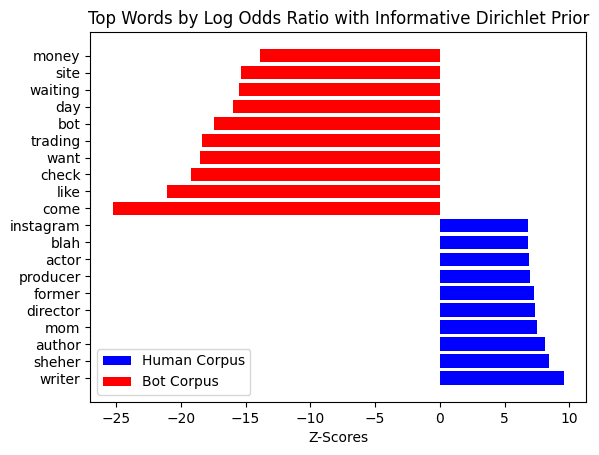

In [47]:
prior_corpus = twitter_translated_embeddings_df.description_en.tolist()
human_corpus = twitter_translated_embeddings_df[human_indices].description_en.tolist()
bot_corpus = twitter_translated_embeddings_df[bot_indices].description_en.tolist()

zscores = lodp(human_corpus, bot_corpus, prior_corpus)
plot_top_words(zscores)

Interpreting Z scores
- Larger |z|: difference between occurrence of a word in human and bot corpora is more significant
- Positive z: Word is more common in human profile descriptions
- Negative z: Word is more common in bot profile descriptions

## Non-parametric Distributional Test on Text Embeddings

### 3. Mann-Whitney U Test

Null hypothesis (H₀): There is no difference between embedding dimension i for bot and human accounts. 

Alternative hypothesis (H₁): There is a difference between embedding dimension i for bot and human accounts. 

In [51]:
# run this to obtain embeddings 

load_dotenv()

def embed_descriptions(description_df):
    
    model = SentenceTransformer('all-MiniLM-L6-v2', token=os.getenv("HF_API_KEY"))
    embeddings_lst = []

    for i, row in description_df.iterrows():
        if row["description_en"]:
            embeddings = model.encode(row["description_en"])
        else:
            embeddings = np.zeros(384, dtype=float)  # default dim=384
        embeddings_lst.append(embeddings)

        if not i % 1000:
            print(f"progress: {i}")

    description_df["description_en_embeddings"] = embeddings_lst
    
    return description_df

twitter_translated_embeddings_df = embed_descriptions(twitter_translated_embeddings_df)

progress: 0
progress: 1000
progress: 2000
progress: 3000
progress: 4000
progress: 5000
progress: 6000
progress: 7000
progress: 8000
progress: 9000
progress: 10000
progress: 11000
progress: 12000
progress: 13000
progress: 14000
progress: 15000
progress: 16000
progress: 17000
progress: 18000
progress: 19000
progress: 20000
progress: 21000
progress: 22000
progress: 23000
progress: 24000
progress: 25000
progress: 26000
progress: 27000
progress: 28000
progress: 29000
progress: 30000
progress: 31000
progress: 32000
progress: 33000
progress: 34000
progress: 35000
progress: 36000
progress: 37000


In [52]:
def transpose_embeddings(embeddings_df):
    embeddings = np.vstack(embeddings_df.values)
    return embeddings.T

def mannwhitneyu_test(human_embeddings_df, bot_embeddings_df):
    human_embeddings_T = transpose_embeddings(human_embeddings_df)
    bot_embeddings_T = transpose_embeddings(bot_embeddings_df)
    dims = human_embeddings_T.shape[0]
    
    results = {"dimension": [], "statistic": [], "p": []}

    for dim in range(dims):
        human_sample = human_embeddings_T[dim]
        bot_sample = bot_embeddings_T[dim]
        statistic, p_value = mannwhitneyu(human_sample, bot_sample, alternative='two-sided')
        
        results["dimension"].append(dim)
        results["statistic"].append(statistic)
        results["p"].append(p_value)
    
    return pd.DataFrame(results).sort_values(by="p")

human_embeddings_df = twitter_translated_embeddings_df[human_indices].description_en_embeddings
bot_embeddings_df = twitter_translated_embeddings_df[bot_indices].description_en_embeddings
mannwhitney_df = mannwhitneyu_test(human_embeddings_df, bot_embeddings_df)

alpha = 0.05 / mannwhitney_df.shape[0]  # Bonferroni correction
significant_dims = mannwhitney_df[mannwhitney_df["p"] <= alpha]

In [53]:
significant_dims

,dimension,statistic,p
319,319,111689169.0,0.000000e+00
223,223,119048578.0,0.000000e+00
351,351,192506666.0,0.000000e+00
99,99,191745187.0,0.000000e+00
157,157,188960493.0,1.155398e-266
...,...,...,...
138,138,159232326.5,6.606003e-05
8,8,151561475.0,6.819844e-05
253,253,159209031.5,7.313900e-05
237,237,159154549.5,9.259776e-05


### 4. Energy Distance Test
Null hypothesis (H₀): The embeddings of human and bot descriptions come from the same distribution in semantic space. There is no significant difference in the overall embedding structure between bots and humans.

Alternative hypothesis (H₁): The embeddings of human and bot descriptions are drawn from different distributions. Implies bots and humans use linguistically or semantically distinct patterns in their profile descriptions.

In [56]:
# Samppling to reduce compute time
size = 5000
idx_human = np.random.choice(human_embeddings_df.values.shape[0], size, replace=False)
idx_bot = np.random.choice(bot_embeddings_df.values.shape[0], size, replace=False)

human_embeddings_sample = np.vstack(human_embeddings_df.iloc[idx_human])
bot_embeddings_sample = np.vstack(bot_embeddings_df.iloc[idx_bot])

# Energy test
stat, pval = Energy().test(human_embeddings_sample, bot_embeddings_sample, reps=100)
print(f"test-statistic: {stat}")
print(f"p-value: {pval}")

/Users/han-ying/Downloads/DSA4263 - twitter/twitter_bots_env/lib/python3.13/site-packages/hyppo/tools/common.py:204: RuntimeWarning: The number of replications is low (under 1000), and p-value calculations may be unreliable. Use the p-value result, with caution!
  warnings.warn(msg, RuntimeWarning)


test-statistic: 0.04144163340088491
p-value: 1.4994752164770953e-137


Based on the Mann-Whitney U Test on each of the embedding dimension, there are 308 / 384 dimensions that differ significantly.

Combined with ther results of the energy distance test, which implies that the embeddings of human and bot descriptions are frawn from different distributions, we can conclude that bots and humans use linguistically or semantically distinct patterns in their profile descriptions

# Hypothesis 3: Human vs Bot usernames have distinct linguistic patterns (dictionary words, names)

## Feature 1: Normalized Entropy

Entropy measures the randomness/unpredictability of characters in a username. Higher entropy suggests more random character combinations, while lower entropy suggests structured patterns.

**Formula:** 
- Shannon Entropy: $H(X) = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)$
- Normalized Entropy: $H_{norm} = \frac{H(X)}{\log_2(n)}$ where n is the length of the username

Normalized entropy ranges from 0 to 1, where:
- **0** = completely predictable (all same character)
- **1** = maximum randomness (all characters equally likely)

**Example:**
- "ajk29f88d" (length = 9): 0.489
- "john.smith" (kength = 10): 0.518

In [39]:
def calculate_entropy(username):
    """
    Calculate the normalized Shannon entropy of a username.
    
    Higher entropy = more random (typical of bots)
    Lower entropy = more structured (typical of humans)
    """
    if not username or len(username) == 0:
        return 0
    
    # Convert to lowercase for consistency
    username = username.lower()
    
    # Count character frequencies
    char_counts = Counter(username)
    length = len(username)
    
    # Calculate Shannon entropy
    entropy = 0
    for count in char_counts.values():
        probability = count / length
        if probability > 0:
            entropy -= probability * np.log2(probability)
    
    # Normalize by maximum possible entropy (log2 of string length)
    max_entropy = np.log2(length) if length > 1 else 1
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    
    return normalized_entropy

In [40]:

# Apply to all usernames
twitter_accounts_df['username_entropy'] = twitter_accounts_df['screen_name'].apply(calculate_entropy)

# Display examples
print("Examples of username entropy:")
print("\nLow entropy (structured) usernames:")
print(twitter_accounts_df.nsmallest(5, 'username_entropy')[['screen_name', 'username_entropy', 'account_type']])
print("\nHigh entropy (random) usernames:")
print(twitter_accounts_df.nlargest(5, 'username_entropy')[['screen_name', 'username_entropy', 'account_type']])

Examples of username entropy:

Low entropy (structured) usernames:
           screen_name  username_entropy account_type
7954     ceeeeceeeeeee          0.167381          bot
30392  1111111111111n_          0.179130        human
13803     wwswwswwswws          0.256152          bot
18703       Bbcccccccb          0.265295          bot
33189  ____________CYN          0.265920        human

High entropy (random) usernames:
         screen_name  username_entropy account_type
2064  dorathy_pingel               1.0        human
3123  JulieSchwartz1               1.0        human
3474  cruzandelights               1.0          bot
3652  Inyourhead24_7               1.0        human
9372  qjucopmldt1568               1.0        human


### Hypothesis Test

- Null hypothesis (H₀): the distribution of username entropy for bots and humans is the same.
- Alternative hypothesis (H₁): bot usernames have a different (likely lower/higher) entropy than human usernames.

C:\Users\Richelle\AppData\Local\Temp\ipykernel_15452\2159814509.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


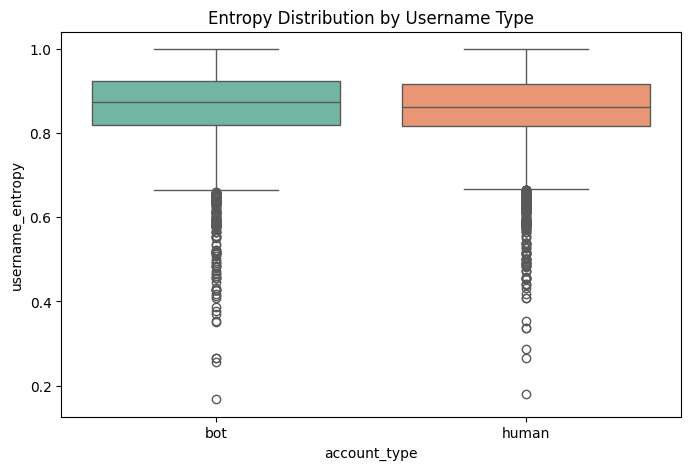

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(
    data=twitter_accounts_df,
    x="account_type",
    y="username_entropy",
    palette="Set2"   # choose any: "Set2", "Paired", "Pastel1", "coolwarm", etc.
)

plt.title("Entropy Distribution by Username Type")
plt.show()

Since entropy values are continuous and non-normal in most username datasets, use a non-parametric test like the Mann–Whitney U test.

In [42]:
# Split into groups
bots = twitter_accounts_df.loc[twitter_accounts_df["account_type"]=="bot", "username_entropy"]
humans = twitter_accounts_df.loc[twitter_accounts_df["account_type"]=="human", "username_entropy"]

# two-tailed test (alternative = 'two-sided')
stat, p_value = mannwhitneyu(bots, humans, alternative="two-sided")
print(f"U statistic = {stat:.3f}, p-value = {p_value:.4f}")

U statistic = 162216513.500, p-value = 0.0000


In [43]:
print("Median entropy (bots):", bots.median())
print("Median entropy (humans):", humans.median())


Median entropy (bots): 0.8752746979566217
Median entropy (humans): 0.863489053434765


In [44]:
n1, n2 = len(bots), len(humans)
r_rb = 1 - (2 * stat) / (n1 * n2)
delta = (2 * stat) / (n1 * n2) - 1
print(f"Rank-biserial correlation (r_rb): {r_rb:.3f}")
print(f"Cliff's delta: {delta:.3f}")


Rank-biserial correlation (r_rb): -0.044
Cliff's delta: 0.044


A Mann–Whitney U test revealed a statistically significant difference in username entropy between bot and human accounts (U = 162,216,513.5, p < 0.001).
However, the effect size was minimal (Cliff’s δ = 0.044, r = 0.044) with medians differing only be 0.01, indicating that although bots and humans differ slightly, the practical magnitude of this difference is very small.
In other words, both groups show broadly similar levels of randomness in username structure.

## Feature 2: Valid Word Ratio

Measures what proportion of the username consists of recognizable dictionary words or common name patterns. Humans tend to use real words and names, while bots use random character combinations.

**Approach:**
1. Split username by common delimiters (_, numbers, case changes)
2. Check each segment against:
   - Common English words (using a basic dictionary)
   - Common name patterns
3. Calculate ratio of valid segments to total segments

In [45]:
# Build a basic dictionary of common English words and names
# In practice, you could use a more comprehensive dictionary like NLTK's words corpus
common_words = {
    'the', 'be', 'to', 'of', 'and', 'in', 'that', 'have', 'it', 'for', 'not', 'on', 'with', 'he', 'as', 'you',
    'do', 'at', 'this', 'but', 'his', 'by', 'from', 'they', 'we', 'say', 'her', 'she', 'or', 'an', 'will', 'my',
    'one', 'all', 'would', 'there', 'their', 'what', 'so', 'up', 'out', 'if', 'about', 'who', 'get', 'which',
    'go', 'me', 'when', 'make', 'can', 'like', 'time', 'no', 'just', 'him', 'know', 'take', 'people', 'into',
    'year', 'your', 'good', 'some', 'could', 'them', 'see', 'other', 'than', 'then', 'now', 'look', 'only',
    'come', 'its', 'over', 'think', 'also', 'back', 'after', 'use', 'two', 'how', 'our', 'work', 'first', 'well',
    'way', 'even', 'new', 'want', 'because', 'any', 'these', 'give', 'day', 'most', 'us',
    # Twitter-specific
    'tweet', 'twitter', 'follow', 'real', 'official', 'news', 'info', 'daily', 'update', 'live', 'world',
    # Common username components
    'best', 'top', 'super', 'big', 'little', 'young', 'old', 'true', 'real', 'the', 'love', 'life', 'art',
    'music', 'photo', 'game', 'sport', 'tech', 'digital', 'online', 'web', 'net', 'blog', 'fan', 'pro',
    'king', 'queen', 'master', 'lord', 'lady', 'sir', 'mr', 'mrs', 'miss', 'dr', 'prof'
}

common_names = {
    'john', 'mary', 'james', 'robert', 'michael', 'william', 'david', 'richard', 'joseph', 'thomas',
    'charles', 'christopher', 'daniel', 'matthew', 'anthony', 'donald', 'mark', 'paul', 'steven', 'andrew',
    'sarah', 'jennifer', 'lisa', 'karen', 'nancy', 'betty', 'helen', 'sandra', 'donna', 'carol',
    'emily', 'jessica', 'ashley', 'amanda', 'melissa', 'deborah', 'stephanie', 'rebecca', 'laura', 'sharon',
    'alex', 'chris', 'sam', 'pat', 'taylor', 'jordan', 'morgan', 'casey', 'jamie', 'riley'
}

def split_username(username):
    """
    Split username into segments by underscores, numbers, and camelCase.
    """
    # Replace underscores with spaces
    username = username.replace('_', ' ')
    
    # Split on numbers
    username = re.sub(r'(\d+)', r' \1 ', username)
    
    # Split camelCase (insert space before uppercase letters)
    username = re.sub(r'([a-z])([A-Z])', r'\1 \2', username)
    
    # Split into segments and filter out empty strings and numbers
    segments = [seg.lower().strip() for seg in username.split() if seg.strip() and not seg.isdigit()]
    
    return segments

def calculate_valid_word_ratio(username):
    """
    Calculate the ratio of valid words/names in the username.
    
    Higher ratio = more real words (typical of humans)
    Lower ratio = more random strings (typical of bots)
    """
    if not username or len(username) == 0:
        return 0
    
    segments = split_username(username)
    
    if len(segments) == 0:
        return 0
    
    valid_count = 0
    for segment in segments:
        # Check if segment is a common word or name
        if segment in common_words or segment in common_names:
            valid_count += 1
        # Check if it's at least 3 characters and looks like a word (has vowels)
        elif len(segment) >= 3 and any(c in 'aeiou' for c in segment):
            # Give partial credit for word-like strings
            vowel_ratio = sum(1 for c in segment if c in 'aeiou') / len(segment)
            if 0.2 <= vowel_ratio <= 0.6:  # Reasonable vowel ratio
                valid_count += 0.5
    
    return valid_count / len(segments)

# Apply to all usernames
twitter_accounts_df['valid_word_ratio'] = twitter_accounts_df['screen_name'].apply(calculate_valid_word_ratio)

# Display examples
print("Examples of valid word ratio:")
print("\nLow ratio (random) usernames:")
print(twitter_accounts_df.nsmallest(10, 'valid_word_ratio')[['screen_name', 'valid_word_ratio', 'account_type']])
print("\nHigh ratio (word-based) usernames:")
print(twitter_accounts_df.nlargest(10, 'valid_word_ratio')[['screen_name', 'valid_word_ratio', 'account_type']])

Examples of valid word ratio:

Low ratio (random) usernames:
         screen_name  valid_word_ratio account_type
47            mu2060               0.0          bot
54            tlc614               0.0          bot
75   poygxvwsrtvrp21               0.0          bot
88          SSDGM666               0.0        human
89    Odiotuttigioia               0.0          bot
113            qty_3               0.0          bot
120          nai8478               0.0        human
121          eye__vy               0.0        human
127         feIIati0               0.0        human
139           EA9625               0.0        human

High ratio (word-based) usernames:
         screen_name  valid_word_ratio account_type
456     JosephMorgan               1.0        human
1058  787_to_the_203               1.0          bot
1379   james_riley12               1.0        human
1908    Amanda122986               1.0          bot
2128       KingJames               1.0        human
2231          Alex1

In [46]:
# Split into groups
bots = twitter_accounts_df.loc[twitter_accounts_df["account_type"] == "bot", "valid_word_ratio"]
humans = twitter_accounts_df.loc[twitter_accounts_df["account_type"] == "human", "valid_word_ratio"]

# one-tailed test: H1 = humans > bots
stat, p_value = mannwhitneyu(humans, bots, alternative="greater")
print(f"U statistic = {stat:.3f}, p-value = {p_value:.4f}")

median_bots = bots.median()
median_humans = humans.median()
print("Median valid word ratio (bots):", median_bots)
print("Median valid word ratio (humans):", median_humans)

U statistic = 166089135.500, p-value = 0.0000
Median valid word ratio (bots): 0.5
Median valid word ratio (humans): 0.5


In [47]:
n1, n2 = len(bots), len(humans)
r_rb = 1 - (2 * stat) / (n1 * n2)
delta = (2 * stat) / (n1 * n2) - 1
print(f"Rank-biserial correlation (r_rb): {r_rb:.3f}")
print(f"Cliff's delta: {delta:.3f}")


Rank-biserial correlation (r_rb): -0.069
Cliff's delta: 0.069


A Mann–Whitney U test revealed a statistically significant difference in valid word ratio between bot and human accounts.
However, the effect size was minimal (Cliff’s δ = 0.069, r = 0.069) with medians being the same, indicating that although bots and humans differ slightly, the practical magnitude of this difference is very small.

## Feature 3: Max Run Length

Bots sometimes generate usernames with zero padding or repeated symbols (bot_0000123, user1111),
whereas humans rarely use long identical runs.

In [48]:
def max_run_length(s: str) -> int:
    """Return the length of the longest consecutive repeated character run."""
    if not s:
        return 0
    runs = re.findall(r"(.)\1*", s)
    return max(len(run) for run in runs)

twitter_accounts_df["max_run_length"] = twitter_accounts_df["screen_name"].apply(max_run_length)

C:\Users\Richelle\AppData\Local\Temp\ipykernel_15452\1797823133.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


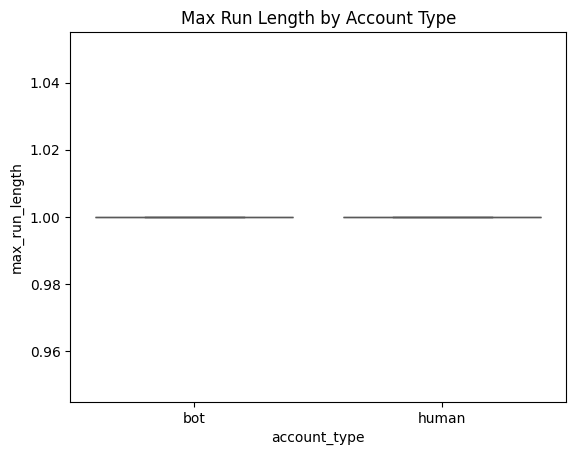

In [49]:
sns.boxplot(
    data=twitter_accounts_df,
    x="account_type",
    y="max_run_length",
    palette="Set2"
)
plt.title("Max Run Length by Account Type")
plt.show()


In [50]:
bots = twitter_accounts_df.loc[twitter_accounts_df["account_type"]=="bot", "max_run_length"]
humans = twitter_accounts_df.loc[twitter_accounts_df["account_type"]=="human", "max_run_length"]

stat, p = mannwhitneyu(bots, humans, alternative="two-sided")
print(f"U={stat:.3f}, p={p:.4e}")
print("Median run length (bots):", bots.median())
print("Median run length (humans):", humans.median())

U=155393262.500, p=1.0000e+00
Median run length (bots): 1.0
Median run length (humans): 1.0


In [51]:
twitter_accounts_df["max_run_length_ratio"] = twitter_accounts_df["max_run_length"] / twitter_accounts_df["screen_name"].str.len()

A Mann–Whitney U test revealed a non statistically significant difference in max run length between bot and human accounts.

## Feature 4: Keyboard-Pattern Flags

Bot usernames often contain simple sequential patterns like
"qwerty", "asdf", "123", "abc", "abcd", etc.


In [52]:
def keyboard_pattern_flag(s: str) -> int:
    """Return 1 if username contains common sequential keyboard or digit patterns."""
    if not s:
        return 0
    s_lower = s.lower()

    common_patterns = [
        "qwerty", "asdf", "zxcv", "123", "234", "345", "456", "567", "678", "789",
        "abc", "abcd", "xyz", "pass", "test", "user"
    ]
    for p in common_patterns:
        if p in s_lower:
            return 1
    return 0

twitter_accounts_df["keyboard_pattern_flag"] = twitter_accounts_df["screen_name"].apply(keyboard_pattern_flag)


In [53]:
pattern_rate = (
    twitter_accounts_df.groupby("account_type")["keyboard_pattern_flag"]
    .mean()
    .reset_index(name="pattern_rate")
)
print(pattern_rate)


  account_type  pattern_rate
0          bot      0.007565
1        human      0.003918


Test with chi-square or Fisher’s exact test (since binary):

In [54]:
from scipy.stats import chi2_contingency

cont_table = pd.crosstab(twitter_accounts_df["account_type"],
                         twitter_accounts_df["keyboard_pattern_flag"])
chi2, p, dof, exp = chi2_contingency(cont_table)
print(cont_table)
print(f"Chi-square={chi2:.3f}, p-value={p:.4e}")


keyboard_pattern_flag      0   1
account_type                    
bot                    12331  94
human                  24915  98
Chi-square=20.937, p-value=4.7475e-06


A chi-square test of independence showed a significant relationship between account type and keyboard-pattern usage, χ²(1, N = 37 438) = 20.94, p < 0.001, Cramér’s V = 0.02.
Bots were roughly twice as likely as humans to include sequential keyboard or digit patterns (0.76 % vs 0.39 %), suggesting that such patterns, while uncommon overall, are a mild indicator of automated naming behavior.

## Additional Analysis of username structure

In [55]:
# Calculate additional features
twitter_accounts_df['username_length'] = twitter_accounts_df['screen_name'].str.len()
twitter_accounts_df['num_digits'] = twitter_accounts_df['screen_name'].apply(lambda x: sum(c.isdigit() for c in x))
twitter_accounts_df['num_underscores'] = twitter_accounts_df['screen_name'].str.count('_')
twitter_accounts_df['has_numbers'] = twitter_accounts_df['num_digits'] > 0
twitter_accounts_df['num_uppercase'] = twitter_accounts_df['screen_name'].apply(lambda x: sum(c.isupper() for c in x))
twitter_accounts_df['consonant_clusters'] = twitter_accounts_df['screen_name'].apply(
    lambda x: len(re.findall(r'[bcdfghjklmnpqrstvwxyz]{3,}', x.lower()))
)

# Calculate ratios (already normalized to 0-1 as they are proportions)
twitter_accounts_df['digit_ratio'] = twitter_accounts_df['num_digits'] / twitter_accounts_df['username_length']
twitter_accounts_df['uppercase_ratio'] = twitter_accounts_df['num_uppercase'] / twitter_accounts_df['username_length']
twitter_accounts_df['consonant_cluster_ratio'] = twitter_accounts_df['consonant_clusters'] / twitter_accounts_df['username_length']

# Normalize additional features to 0-1 scale for comparison
from sklearn.preprocessing import MinMaxScaler
scaler_length = MinMaxScaler()
scaler_underscores = MinMaxScaler()

twitter_accounts_df['username_length_normalized'] = scaler_length.fit_transform(twitter_accounts_df[['username_length']])
twitter_accounts_df['num_underscores_normalized'] = scaler_underscores.fit_transform(twitter_accounts_df[['num_underscores']])

# Summary by account type
print("=" * 80)
print("ADDITIONAL USERNAME CHARACTERISTICS")
print("=" * 80)

for feature in ['username_length', 'digit_ratio', 'num_underscores', 'consonant_clusters']:
    print(f"\n{feature.upper().replace('_', ' ')}:")
    print("-" * 80)
    summary = twitter_accounts_df.groupby('account_type')[feature].describe()[['mean', 'std', '50%']]
    print(summary)

# Proportion with numbers
print("\n\nPROPORTION WITH NUMBERS:")
print("-" * 80)
print(twitter_accounts_df.groupby('account_type')['has_numbers'].value_counts(normalize=True).unstack())

print("\n\nNORMALIZED/RATIO FEATURES:")
print("-" * 80)
for feature in ['username_length_normalized', "num_underscores_normalized" ]:
    print(f"\n{feature.upper().replace('_', ' ')}:")
    print("-" * 80)
    summary = twitter_accounts_df.groupby('account_type')[feature].describe()[['mean', 'std', '50%']]
    print(summary)

ADDITIONAL USERNAME CHARACTERISTICS

USERNAME LENGTH:
--------------------------------------------------------------------------------
                   mean       std   50%
account_type                           
bot           11.139638  2.701248  11.0
human         11.095230  2.611676  11.0

DIGIT RATIO:
--------------------------------------------------------------------------------
                  mean       std  50%
account_type                         
bot           0.097801  0.164756  0.0
human         0.048131  0.111557  0.0

NUM UNDERSCORES:
--------------------------------------------------------------------------------
                  mean       std  50%
account_type                         
bot           0.193481  0.493916  0.0
human         0.185983  0.471938  0.0

CONSONANT CLUSTERS:
--------------------------------------------------------------------------------
                  mean       std  50%
account_type                         
bot           0.512837  0.647

## Username Feature Profile

This radar chart compares the average username characteristics between human and bot accounts using normalized features:
- Entropy (randomness of characters)
- Valid Word Ratio (dictionary/name components)
- Normalized Username Length
- Digit Ratio
- Uppercase Ratio
- Consonant Cluster Ratio
- Normalized Underscores Count
- Max Run Length (normalized by username length)
- Keyboard Pattern Flag (rate of usernames with sequential patterns)

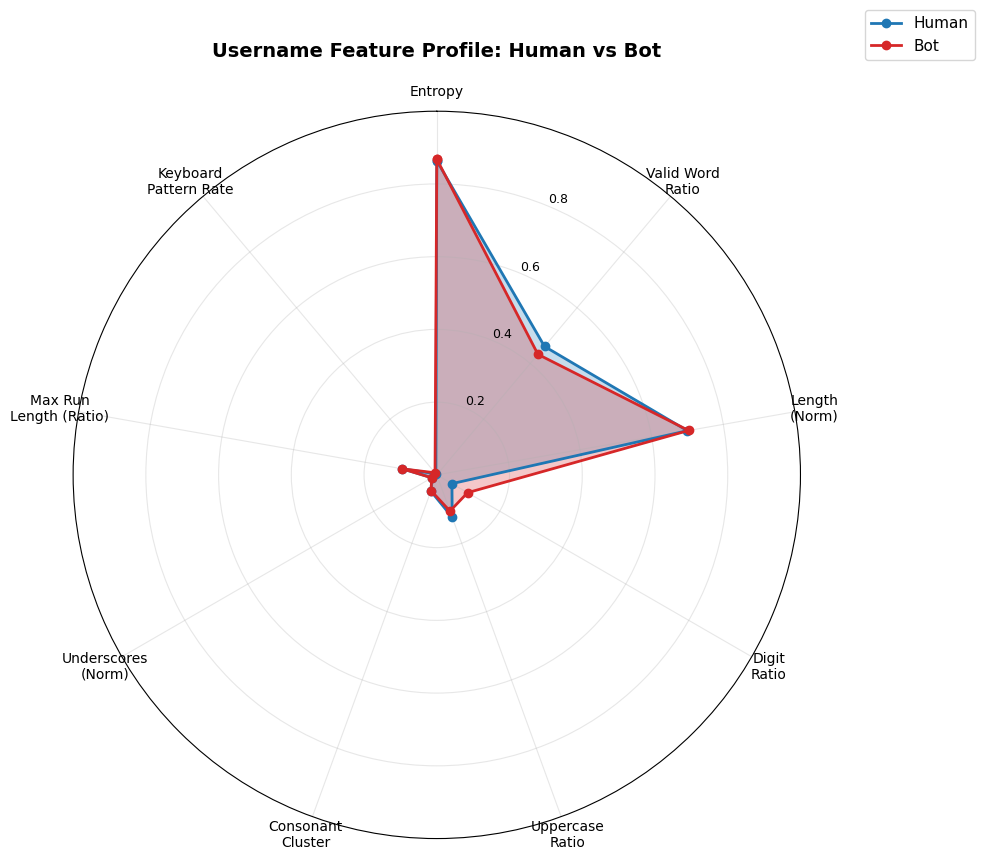

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# features to compare (all on ~0-1 scale or proportions)
radar_features = [
    ('username_entropy', 'Entropy'),
    ('valid_word_ratio', 'Valid Word\nRatio'),
    ('username_length_normalized', 'Length\n(Norm)'),
    ('digit_ratio', 'Digit\nRatio'),
    ('uppercase_ratio', 'Uppercase\nRatio'),
    ('consonant_cluster_ratio', 'Consonant\nCluster'),
    ('num_underscores_normalized', 'Underscores\n(Norm)'),
    ('max_run_length_ratio', 'Max Run\nLength (Ratio)'),
    ('keyboard_pattern_flag', 'Keyboard\nPattern Rate')
]

# Check required columns
missing = [col for col, _ in radar_features if col not in twitter_accounts_df.columns]
if missing:
    raise ValueError(f"Missing required columns for radar chart: {missing}.\n"
                     "Please ensure all features are calculated.")

# Compute mean per feature for each account type
human_means = []
bot_means = []
labels = []
for col, label in radar_features:
    vals_h = twitter_accounts_df.loc[twitter_accounts_df['account_type']=='human', col].astype(float)
    vals_b = twitter_accounts_df.loc[twitter_accounts_df['account_type']=='bot', col].astype(float)
    # Clip to [0, 1] safety for ratios/norms (keyboard flag already 0/1)
    vals_h = vals_h.clip(0, 1)
    vals_b = vals_b.clip(0, 1)
    human_means.append(vals_h.mean())
    bot_means.append(vals_b.mean())
    labels.append(label)

# Radar setup
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

human_vals = human_means + human_means[:1]
bot_vals = bot_means + bot_means[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Polar settings
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], fontsize=9)
ax.grid(True, alpha=0.3)

# Plot
ax.plot(angles, human_vals, 'o-', linewidth=2, label='Human', color='tab:blue', markersize=6)
ax.fill(angles, human_vals, alpha=0.25, color='tab:blue')

ax.plot(angles, bot_vals, 'o-', linewidth=2, label='Bot', color='tab:red', markersize=6)
ax.fill(angles, bot_vals, alpha=0.25, color='tab:red')

ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15), fontsize=11)
ax.set_title('Username Feature Profile: Human vs Bot', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

The radar chart shows that human and bot username profiles are nearly overlapping across all nine features (entropy, valid word ratio, normalized length, digit ratio, uppercase ratio, consonant cluster ratio, normalized underscores, normalized max run length, and keyboard pattern rate). Any visible gaps are minimal and within expected variability, indicating no practically meaningful difference in username structure between the two groups in this dataset. Prior statistical tests, while showed statistical significance also revealed low effect size. As such, username features alone are insufficient to distinguish bots from humans and should be combined with stronger behavioral or content-based signals for reliable classification.


## Output to CSV (username features)

In [59]:
twitter_accounts_df.columns

Index(['created_at', 'default_profile', 'default_profile_image', 'description',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'id', 'lang', 'location', 'profile_background_image_url',
       'profile_image_url', 'screen_name', 'statuses_count', 'verified',
       'average_tweets_per_day', 'account_age_days', 'account_type',
       'username_entropy', 'max_run_length', 'keyboard_pattern_flag',
       'valid_word_ratio', 'username_length', 'num_digits', 'num_underscores',
       'has_numbers', 'num_uppercase', 'consonant_clusters', 'digit_ratio',
       'uppercase_ratio', 'consonant_cluster_ratio',
       'username_length_normalized', 'num_underscores_normalized',
       'max_run_length_ratio'],
      dtype='object')

In [60]:
output_path = "../data/twitter_bots_with_username_features.csv"
twitter_accounts_df.to_csv(output_path, index=False)
print(f"Wrote {len(twitter_accounts_df)} rows and {len(twitter_accounts_df.columns)} columns to: {output_path}")

Wrote 37438 rows and 35 columns to: ../data/twitter_bots_with_username_features.csv
